# The gate will be optimised for a maximum split allocation, the gate time and the auxiliary qubit detuning.

In [12]:
from NotebookLib import *
simulations  = reload(SuperoperatorSimulations)
with HiddenPrints():    
    sim = simulations.Simulation('O-x-O')

# Run Optimization of Simulations

In [13]:
sim.Create_Parameter_Dict() #Reset the values according to the file

gamma_val = sim.parameters['gamma']

# Global Parameters 
kSweep = [0.99, 0.95]
CSweep = [25,50,100]
SplitSweep = [3,5,10]

# Optimization Accuracy  --- Give odd numbers
DeNum = 11
DENum = 11
tgNum = 11

SplitSweep = [spl*gamma_val for spl in SplitSweep]
AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep]

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 1
for (k, C_val , MaxSplit) in AllParams:
    c_val = k/ (4-4*k)
    sim.parameters['v'] = np.sqrt( c_val * (sim.parameters['kappa_b']*sim.parameters['kappa_c'] ) )


    # Optimization Parameters  --- Give odd numbers
    # De
    DeSweep = np.linspace(0,MaxSplit , num = DeNum)
    # DE
    
    DESweep = np.linspace(0.8 , 1.2 , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    
    tgSweep = np.linspace(0.98,1.02 , num = tgNum)

    ParamsSweep = [DeSweep ,DESweep,tgSweep ]

    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)

    
    for (ii,De_val) in enumerate(DeSweep):
        for (jj,DE_val) in enumerate(DESweep):
            for (kk,tgRatio) in enumerate(tgSweep):
                progressBar(CurrentNumberOfSimulations, math.prod(ResultsShape)*TotalParamElems, barLength = 60)
                CurrentNumberOfSimulations += 1

                De0_val =  De_val - MaxSplit
                
                sim.parameters['De']  = De_val
                sim.parameters['De0'] = De0_val
                sim.parameters['DE'] = DE_val
                

                sim.Numerical_Substitution()

                gate_time, f_prob , infidelity = sim.Simulate(C_val, GateTimeModifier = tgRatio)
            

                GateTime[ii][jj][kk] = gate_time
                Psucc[ii][jj][kk]    = 1-f_prob
                Fidelity[ii][jj][kk] = 1-infidelity
                
    Directory = f'OptimizationResults/ResC{C_val}_k{k}_Spl{MaxSplit}_e{DeNum}_E{DENum}_t{tgNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
        np.save(Directory+f'/Fidelity',Fidelity)
        np.save(Directory+f'/GateTime',GateTime)
        np.save(Directory+f'/Psucc',Psucc)



Progress: [----------------------------------------------------------->] 100 %


# Plotting

<>:25: DeprecationWarning: invalid escape sequence \%
<>:26: DeprecationWarning: invalid escape sequence \%
<>:38: DeprecationWarning: invalid escape sequence \D
<>:25: DeprecationWarning: invalid escape sequence \%
<>:26: DeprecationWarning: invalid escape sequence \%
<>:38: DeprecationWarning: invalid escape sequence \D
<ipython-input-21-caedab43f038>:25: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+'\%$\n'
<ipython-input-21-caedab43f038>:26: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=1))+'\%$\n'
<ipython-input-21-caedab43f038>:38: DeprecationWarning: invalid escape sequence \D
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split, $k={kPlot}$\n $(\Delta_e,\Delta_E,t_g)$')


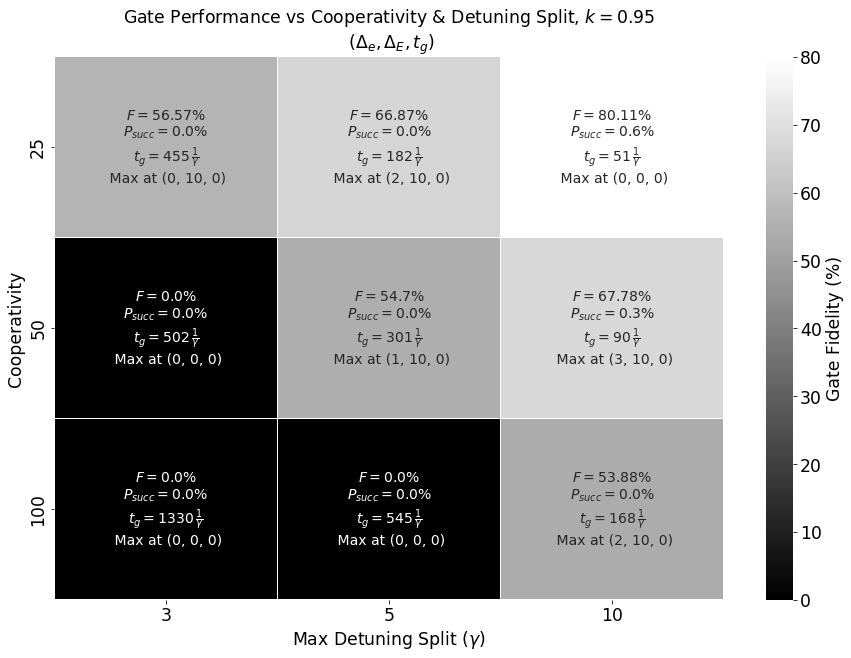

In [21]:
#Complete optimization for Fidelity
import seaborn as sns
kPlot = 0.95

CSweep = [25,50,100]

SplitSweep = [3,5,10]

DeNum = 11
DENum = 11
tgNum = 11

AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
FidelityPlot = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        DataDirectory = f'OptimizationResults/ResC{c}_k{kPlot}_Spl{spl}_e{DeNum}_E{DENum}_t{tgNum}/'
        GateTimeData = np.load(DataDirectory+"GateTime.npy")
        FidelityData = np.load(DataDirectory+"Fidelity.npy")
        PsuccData = np.load(DataDirectory+"Psucc.npy")

        argm = ArgMax(FidelityData)
        FidelityPlot[i][j] = FidelityData[argm]

        AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=1))+'\%$\n'
        AllLabels[i][j] += '$t_g='+ str(int(GateTimeData[argm]))+r' \,\frac{1}{\gamma}$'
        AllLabels[i][j] += f'\n Max at {argm}'


fig, ax = plt.subplots()


ax = sns.heatmap(FidelityPlot*100,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Gate Fidelity (%)'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split, $k={kPlot}$\n $(\Delta_e,\Delta_E,t_g)$')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg')